In [ ]:
# Copyright (c) 2016-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the BSD-style license found in the
# LICENSE file in the root directory of this source tree. An additional grant
# of patent rights can be found in the PATENTS file in the same directory.

# Evaluate pysparnn on Enron data

In [1]:
import numpy as np
import time
import inspect

from scipy.sparse import csr_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.neighbors import LSHForest
from sklearn.feature_extraction import DictVectorizer

In [2]:
# make sure you run 'python setup.py install' first!
import pysparnn

## Get data

In [3]:
# load enron data 
import os
import sys

docs = []
max_docs = 100000
for folder, subs, files in os.walk('maildir'):
    for filename in files:
        with open(os.path.join(folder, filename), 'r') as src:
            txt = ' '.join(src.readlines())
            if len(txt) > 0:
                docs.append(txt)
        if len(docs) > max_docs:
            break                
    if len(docs) > max_docs:
        break

In [4]:
print 'Num docs: {}'.format(len(docs))
print 'Avg doc length: {}'.format(np.mean([len(x.split()) for x in docs]))
words = set()
for doc in docs:
    words.update(doc.split())
print 'Num unique words: {}'.format(len(words))
del words

Num docs: 100001
Avg doc length: 413.757442426
Num unique words: 942676


## Turn documents into vectors

In [5]:
from sklearn.neighbors import LSHForest, NearestNeighbors 
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(decode_error='ignore')

features = csr_matrix(tv.fit_transform(docs))

doc_index = np.array(range(len(docs)))

In [6]:
test_features = features[:2000]
train_features = features[2000:]

## Create an answer key

In [7]:
knn = NearestNeighbors(algorithm='brute', metric='cosine')
        
knn.fit(train_features)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [8]:
t0 = time.time()
# get 1 NN for each document
answers = knn.kneighbors(test_features, n_neighbors=1, return_distance=False)
time.time() - t0

43.259413957595825

In [9]:
bknn = NearestNeighbors(algorithm='ball_tree')
        
bknn.fit(train_features)

t0 = time.time()
# get 1 NN for each document
_ = bknn.kneighbors(test_features, n_neighbors=1, return_distance=False)
time.time() - t0

/Users/spencebeecher/anaconda2/lib/python2.7/site-packages/sklearn/neighbors/base.py:229: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


39.70149898529053

## Build models to compare

In [10]:
t0 = time.time()
snn = pysparnn.MultiClusterIndex(train_features, doc_index, num_indexes=2)
time.time() - t0

92.33221197128296

In [11]:
t0 = time.time()
lshf = LSHForest(n_neighbors=1)
        
lshf.fit(train_features)
time.time() - t0

17.43657684326172

## Compare results

In [12]:
import pysparnn_utils
import time 

In [13]:
t0 = time.time()

results = snn.search(test_features, return_distance=False)

print 'Recall:', pysparnn_utils.recall(answers, results).mean()

snn_time = time.time() - t0
snn_time

Recall: 0.9595


21.88961887359619

In [14]:
# only search one index instead of 2
t0 = time.time()

results = snn.search(test_features, return_distance=False, num_indexes=1)

print 'Recall:', pysparnn_utils.recall(answers, results).mean()

time.time() - t0

Recall: 0.9335


9.252957105636597

In [15]:
t0 = time.time()

results = lshf.kneighbors(test_features, return_distance=False)

print 'Recall:',  pysparnn_utils.recall(answers, results).mean()
lsh_time = time.time() - t0
lsh_time

Recall: 0.7165


72.78718495368958

In [16]:
# LSH is 3x slower than snn
lsh_time / snn_time

3.3251919722315177

# Track Pysparnn vs Brute Force as a function of index size

In [18]:
snn_results = []

for n in np.linspace(1000, 80000, 5):
    feats = train_features[:n]
    
    knn = NearestNeighbors(algorithm='brute', metric='cosine')

    knn.fit(feats)

    # get 1 NN for each document
    t0 = time.time()
    
    answers = knn.kneighbors(test_features, n_neighbors=1, return_distance=False)
    
    knn_time = time.time() - t0
    
    
    ######################
    
    snn = pysparnn.MultiClusterIndex(feats, doc_index, num_indexes=2)
    # only search one index instead of 2
    t0 = time.time()

    results = snn.search(test_features, return_distance=False, num_indexes=1)
    
    snn_time = time.time() - t0
    snn_recall = pysparnn_utils.recall(answers, results).mean()
    
    snn_results.append({
            'n': n,
            'snn_recall': snn_recall , 
            'snn_time': snn_time,
            'knn_recall': 1.0,
            'knn_time': knn_time
        })

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

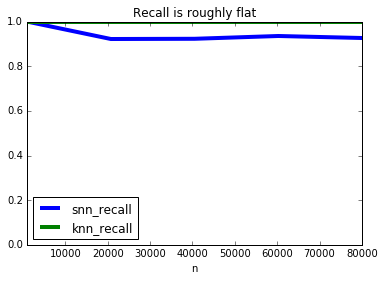

In [26]:
pd.DataFrame(snn_results)[['n', 'snn_recall', 'knn_recall']].plot(x='n', ylim=(0, 1), linewidth=4,
                                                                 title='Recall is roughly flat')

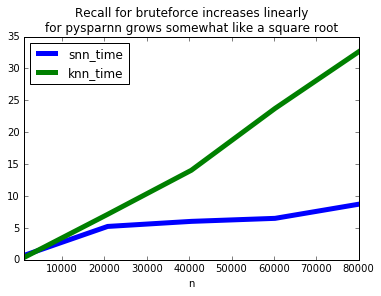

In [28]:
df = pd.DataFrame(snn_results)[['n', 'snn_time', 'knn_time']]
df.plot(x='n', linewidth=5,
        title='Recall for bruteforce increases linearly\nfor pysparnn grows somewhat like a square root')